In [2]:

import numpy as np
import matplotlib.pyplot as plt
import helpers as hp
from pathlib import Path
from config import PathConfigs
import os
import pandas as pd
import plotly.graph_objects as go

from scipy.stats import entropy



In [3]:
string = "test_var"
globals()[string] = 42

# thats cool, didnt know you could dynamically declare variables
test_var

42

In [4]:
Delta = 0.5
mu = 1.0
V_c = np.sqrt(mu**2 + Delta ** 2)

V_c

1.118033988749895

In [5]:

save_plots = True

dirname = "reruncorr_stong_dis_test"
save_dir = Path(PathConfigs.DATA/dirname/"Plots")

os.makedirs(save_dir, exist_ok=True)





In [6]:

barrier_left_conductance_left_arr = hp.np_load_wrapped("barrier_left_conductance_left_arr", dirname)
barrier_right_conductance_right_arr = hp.np_load_wrapped("barrier_right_conductance_right_arr", dirname)
barrier_left_conductance_right_arr = hp.np_load_wrapped("barrier_left_conductance_right_arr", dirname)
barrier_right_conductance_left_arr = hp.np_load_wrapped("barrier_right_conductance_left_arr", dirname)
dIdVs_left_arr = hp.np_load_wrapped("dIdVs_left_arr", dirname)
dIdVs_right_arr = hp.np_load_wrapped("dIdVs_right_arr", dirname)
energies = hp.np_load_wrapped("energies", dirname)
pdi_arr = hp.np_load_wrapped("pdi_data", dirname)
Conductance_matrix = hp.np_load_wrapped("Conductance_matrix", dirname)
gamma_sq_arr = hp.np_load_wrapped("gamma_sq_arr", dirname)
mp_arr = hp.np_load_wrapped("mp_arr", dirname)
rG_corr = hp.np_load_wrapped("rG_corr", dirname)
params_list = hp.np_load_wrapped("params_list", dirname)


#ldos = hp.np_load_wrapped("LDOS", dirname)

#return [mu_pm * V_c, vz_raw, pdi_val]
#new_pdi_dat = np.asarray([[pdr[0]/V_c, pdr[1]*V_c, pdr[2]] for pdr in pdi_arr])


params_list

array([[0.000e+00, 5.000e-01, 6.000e-01],
       [1.000e+00, 5.000e-01, 6.200e-01],
       [2.000e+00, 5.000e-01, 6.400e-01],
       ...,
       [2.598e+03, 1.500e+00, 1.560e+00],
       [2.599e+03, 1.500e+00, 1.580e+00],
       [2.600e+03, 1.500e+00, 1.600e+00]])

In [7]:
def filter_pdi(pdis, thresh = 0.8):
    for i in range(len(pdis)):
        pdi = pdis[i]
        if pdi > 1.0:
            pdis[i] = 1.00
        elif pdi < 0.0:
            pdis[i] = 0
        
        if thresh:
            if pdi > thresh:
                pdis[i] =  1
            else:
                pdis[i] =  0
                
                
            
    return pdis
    

In [8]:
import numpy as np
import plotly.graph_objects as go

# Assuming pdi_arr and filter_pdi are already defined in your environment
mu = pdi_arr[:, 0]    # y-axis in the plot
V_z = pdi_arr[:, 1]   # x-axis in the plot
I = filter_pdi(pdi_arr[:, 2])  # z-axis (color)
#I = pdi_arr[:, 2]  # z-axis (color)

# Create the interactive Plotly heatmap/contour
fig = go.Figure(data=go.Contour(
    x=V_z,
    y=mu,
    z=I,
    colorscale='Viridis',  # Matches Matplotlib's 'viridis'
    ncontours=100,         # Matches the levels=100 argument
    line_width=0,          # Removes contour lines for a smooth heatmap look
    contours=dict(
        coloring='heatmap',
        showlines=False
    ),
    colorbar=dict(
        title='Intensity (I)'
    )
))

# Label axes and title
# Plotly naturally renders LaTeX enclosed in $ symbols
fig.update_layout(
    title='Winding Number (I vs $\\mu$ and $V_z$)',
    xaxis_title='$V_z$',
    yaxis_title='$\\mu$',
    width=900,
    height=700
)

fig.show()

In [9]:
symm_KL = lambda p, q: 0.5*(entropy(p,q) + entropy(q,p))

thresh = 0.95


#corrs = np.asarray([1 - symm_KL(barrier_left_conductance_left_arr[i,:], barrier_left_conductance_right_arr[i,:]) for i in range(barrier_left_conductance_right_arr.shape[0])])
#corrs = corrs - corrs.min()
#corrs = corrs/corrs.max()

corrs = np.asarray([hp.calc_invariant_metric(barrier_left_conductance_left_arr[i,:], barrier_left_conductance_right_arr[i,:]) for i in range(barrier_left_conductance_right_arr.shape[0])])
#corrs = np.asarray([1.0 if corr > 1 else corr for corr in corrs])
#corrs = np.asarray([0.0 if corr < 0.0 else corr for corr in corrs])
#
#corrs = np.asarray([0.0 if corr < thresh else corr for corr in corrs])
#corrs = np.asarray([1.0 if corr > thresh else corr for corr in corrs])

In [10]:

mu = params_list[:, 1]   # y-axis in the plot
V_z = params_list[:, 2]  # x-axis in the plot
zplot = corrs            # z-axis (color)

# Create the interactive Plotly heatmap/contour
fig = go.Figure(data=go.Contour(
    x=V_z,
    y=mu,
    z=zplot,
    colorscale='Viridis',    # Matches Matplotlib's 'magma'
    ncontours=100,         # Smooth continuous gradient
    line_width=0,          # Removes contour lines
    contours=dict(
        coloring='heatmap',
        showlines=False
    ),
    colorbar=dict(
        title='Intensity (I)'
    )
))

# Label axes and title
fig.update_layout(
    title='Conductance Correlation (vs $\\mu$ and $V_z$)',
    xaxis_title='$V_z$',
    yaxis_title='$\\mu$',
    width=900,
    height=700
)

fig.show()

In [15]:
import numpy as np
import plotly.graph_objects as go

# Assuming params_list, I, and corrs are already defined in your environment
mu  = params_list[:, 1]  # y-axis
V_z = params_list[:, 2]  # x-axis
diff = I - corrs

# 3. Create the interactive Plotly heatmap/contour
fig = go.Figure(data=go.Contour(
    x=V_z,
    y=mu,
    z=diff,
    colorscale='RdBu',     # Matches Matplotlib's 'RdBu'
    ncontours=100,         # Smooth continuous gradient
    line_width=0,          # Removes contour lines
    contours=dict(
        coloring='heatmap',
        showlines=False
    ),
    colorbar=dict(
        title='Intensity (I)'
    )
))

# 4. Label axes and title
fig.update_layout(
    title='W - Corr(G) (vs $\mu$ and $V_z$)',
    xaxis_title='$V_z$',
    yaxis_title='$\mu$',
    width=900,
    height=700
)

fig.show()

# --- Min/Max calculation logic ---
iiidx = 4
max_pos_diff_idx = np.where(diff == diff.max())
max_pos_diff = diff[max_pos_diff_idx]   #[iiidx]
max_pos_diff_mu = mu[max_pos_diff_idx]  #[iiidx]
max_pos_diff_Vz = V_z[max_pos_diff_idx] #[iiidx]

max_neg_diff_idx = np.where(diff == diff.min())
# Left exactly as you had it (without the [iiidx] slice)
max_neg_diff = diff[max_neg_diff_idx]  
max_neg_diff_mu = mu[max_neg_diff_idx]  
max_neg_diff_Vz = V_z[max_neg_diff_idx] 

print(f"Max positive Difference: diff: {max_pos_diff}| mu: {max_pos_diff_mu}| Vz: {max_pos_diff_Vz}| Index: {max_pos_diff_idx}")
print(f"Max negative Difference: diff: {max_neg_diff}| mu: {max_neg_diff_mu}| Vz: {max_neg_diff_Vz}| Index: {max_neg_diff_idx}")

Max positive Difference: diff: [1318.02776669]| mu: [0.62]| Vz: [1.16]| Index: (array([334]),)
Max negative Difference: diff: [-790.33210756]| mu: [0.76]| Vz: [1.22]| Index: (array([694]),)


In [12]:

from plotly.subplots import make_subplots

# --- 1. Define Data ---
mu_1 = pdi_arr[:, 0]
V_z_1 = pdi_arr[:, 1]
z_1 = filter_pdi(pdi_arr[:, 2])

mu_2 = params_list[:, 1]
V_z_2 = params_list[:, 2]
z_2 = corrs

mu_3 = params_list[:, 1]
V_z_3 = params_list[:, 2]
z_3 = I - corrs

# --- 2. Initialize Subplots (Without shared_yaxes) ---
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        'Winding Number', 
        'Conductance Correlation', 
        'W - Corr(G)'
    ),
    horizontal_spacing=0.12  # Increased spacing to make room for Y-ticks on all plots
)

# --- 3. Add Traces ---
# Trace 1
fig.add_trace(go.Contour(
    x=V_z_1, y=mu_1, z=z_1,
    colorscale='Viridis', ncontours=100, line_width=0,
    contours=dict(coloring='heatmap', showlines=False),
    colorbar=dict(title='I', x=0.28, len=0.8, thickness=15)
), row=1, col=1)

# Trace 2
fig.add_trace(go.Contour(
    x=V_z_2, y=mu_2, z=z_2,
    colorscale='Viridis', ncontours=100, line_width=0,
    contours=dict(coloring='heatmap', showlines=False),
    colorbar=dict(title='I', x=0.64, len=0.8, thickness=15)
), row=1, col=2)

# Trace 3
fig.add_trace(go.Contour(
    x=V_z_3, y=mu_3, z=z_3,
    colorscale='RdBu', ncontours=100, line_width=0,
    contours=dict(coloring='heatmap', showlines=False),
    colorbar=dict(title='I', x=1.0, len=0.8, thickness=15)
), row=1, col=3)

# --- 4. Update Layout and Linked Axes ---
fig.update_layout(
    title_text='Phase Diagram Comparisons (vs $\\mu$ and $V_z$)',
    width=1400,
    height=600,
    showlegend=False
)

# Link all X and Y axes together, but force ticks to display on every panel
for i in range(1, 4):
    # Link X axes and show ticks
    fig.update_xaxes(title_text='$V_z$', row=1, col=i, matches='x', showticklabels=True)
    
    # Link Y axes and show ticks. 
    # We only put the Greek letter $\mu$ title on the far left plot to keep it clean, 
    # but the numeric ticks will show on all three.
    if i == 1:
        fig.update_yaxes(title_text='$\\mu$', row=1, col=i, matches='y', showticklabels=True)
    else:
        fig.update_yaxes(row=1, col=i, matches='y', showticklabels=True)

fig.show()

# --- Min/Max Calculation Logic ---
iiidx = 4
max_pos_diff_idx = np.where(z_3 == z_3.max())
max_pos_diff = z_3[max_pos_diff_idx][iiidx]
max_pos_diff_mu = mu_3[max_pos_diff_idx][iiidx]
max_pos_diff_Vz = V_z_3[max_pos_diff_idx][iiidx]

max_neg_diff_idx = np.where(z_3 == z_3.min())
max_neg_diff = z_3[max_neg_diff_idx]  
max_neg_diff_mu = mu_3[max_neg_diff_idx]  
max_neg_diff_Vz = V_z_3[max_neg_diff_idx] 

print(f"Max positive Difference: diff: {max_pos_diff}| mu: {max_pos_diff_mu}| Vz: {max_pos_diff_Vz}")
print(f"Max negative Difference: diff: {max_neg_diff}| mu: {max_neg_diff_mu}| Vz: {max_neg_diff_Vz}")

IndexError: index 4 is out of bounds for axis 0 with size 1

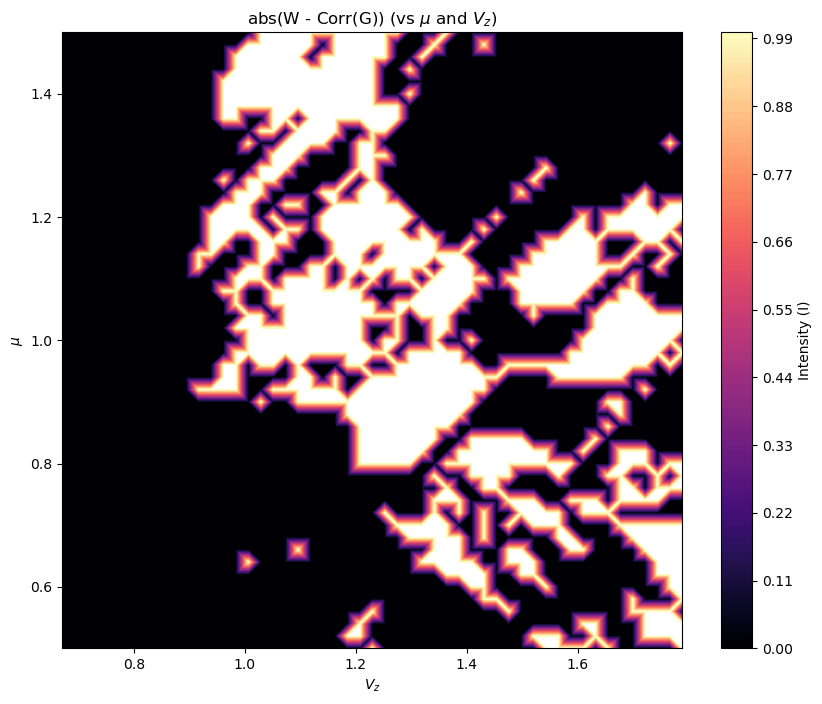

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mu  =  params_list[:, 1]  # x-axis
V_z =  params_list[:, 2]*V_c  # y-axis
#diff = I/I.max() - rG_corr/rG_corr.max()
diff = np.abs(I - corrs)


# 3. Create the heatmap
plt.figure(figsize=(10, 8))

# tricontourf creates a smooth filled contour plot
# levels=100 makes it look like a continuous heatmap
contour = plt.tricontourf(V_z, mu, diff, levels=100, cmap='magma')

# Add a colorbar to show what I values the colors represent
cbar = plt.colorbar(contour)
cbar.set_label('Intensity (I)')

# 4. Label axes
plt.ylabel(r'$\mu$')
plt.xlabel(r'$V_z$')
plt.title('abs(W - Corr(G)) (vs $\mu$ and $V_z$)')

plt.show()

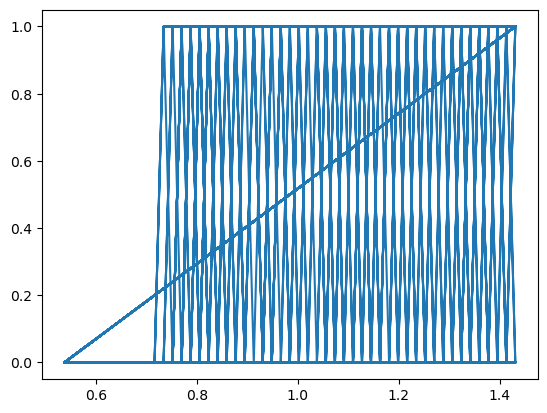

In [ ]:
data = {
    'mu': pdi_arr[:, 0],
    'V_z':pdi_arr[:, 1],
    'I': filter_pdi(pdi_arr[:, 2])
}

df = pd.DataFrame(data = data)

minval = np.min(np.abs(pdi_arr[:, 0] - mu))

val = minval + mu

mudf = df[np.isclose(df['mu'], val,rtol = 1e-6) ]


plt.plot(mudf['V_z']/V_c, mudf['I'])


In [ ]:
mu = 1
Delta = 0.5
V_c = np.sqrt(mu**2 + Delta**2)
num_vz_var = mp_arr.shape[0]
Vz_var = np.linspace(0.3, 1.7, num_vz_var) 
Vzs = Vz_var


len dIdVs_left_arr: (2601, 101)
len Vzs: 2601
len energies: 101


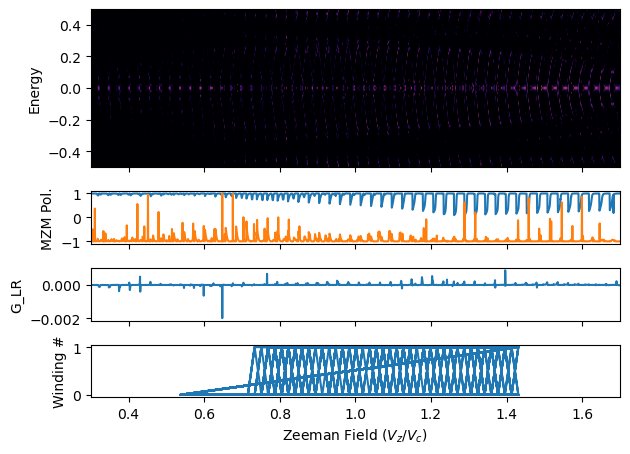

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ... (Previous data generation code: energies, Vz_var, dIdVs_left_arr, etc.) ...

print(f"len dIdVs_left_arr: {dIdVs_left_arr.shape}")
print(f"len Vzs: {len(Vz_var)}")  # Adjusted variable name based on your meshgrid usage
print(f"len energies: {len(energies)}")

# Prepare Grid
Y, X = np.meshgrid(energies, Vz_var)
Z = dIdVs_left_arr

# Update: 3 rows, height ratios [3, 1, 1] to make ax2 and ax3 equal size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})

# --- Plot 1: Heatmap ---
mesh = ax1.pcolormesh(X, Y, Z, cmap='magma', shading='gouraud')
ax1.set_ylabel("Energy") 

# --- Plot 2: MZM Polarization (Top Line Plot) ---
ax2.plot(Vz_var, mp_arr[:, 0])
ax2.plot(Vz_var, mp_arr[:, -1])
ax2.set_ylabel("MZM Pol.")
#ax2.legend() # Optional: added legend since there are two lines

# --- Plot 3: New Graph (Bottom Line Plot) ---
# Replace 'your_y_data' with the data you wish to plot here
ax3.plot(Vz_var, Conductance_matrix[:,0,1]) 
ax3.set_ylabel("G_LR") 

ax4.plot(mudf['V_z']/V_c, mudf['I'])
ax4.set_ylabel("Winding #") 
ax4.set_xlabel(r"Zeeman Field $(V_z/V_c)$") # x-label goes on the bottom-most plot

fig.suptitle(r"")
fig.tight_layout()

plt.show()

In [48]:
def calc_invariant_metric(f1, f2):
    smdiff = np.sum(f1-f2)
    sgn = smdiff/np.abs(smdiff)
    fmax = f2 if sgn < 0 else f1
    fmin = f2 if sgn > 0 else f1
    
    invA = np.sum(fmax)
    
    fn_max = fmax * invA
    fn_min = fmin/np.sum(fmin)
    
    corr = (np.dot(fn_max, fn_min) - invA)/(np.dot(fn_min, fn_min) - invA) 
    
    return corr
    
    
    
    

In [49]:
np.where(corrs == corrs.max())

params_list[693]

array([693.  ,   0.76,   1.2 ])

In [63]:
import numpy as np
import plotly.graph_objects as go

# --- Your existing data processing ---
i = 694
GLL = barrier_left_conductance_left_arr[i, :]
GRR = barrier_left_conductance_right_arr[i, :]

nGRR = GRR/np.max(GRR)
nGLL = GLL/np.max(GLL)

print(calc_invariant_metric(nGRR, nGLL))

# --- Plotly Visualization ---
fig = go.Figure()

# Add the right conductance curve
fig.add_trace(go.Scatter(
    y=nGRR, 
    mode='lines', 
    name='nGRR (Right)'
))

# Add the left conductance curve
fig.add_trace(go.Scatter(
    y=nGLL, 
    mode='lines', 
    name='nGLL (Left)'
))

# Update layout for a cleaner look
fig.update_layout(
    title=f'Normalized Conductance Profiles (Index i={i}, mu={params_list[693][1]}, Vz={params_list[693][2]})',
    xaxis_title='Index / Energy', # Update this to your actual x-axis variable if you have one
    yaxis_title='Normalized Conductance',
    width=800,
    height=500,
    hovermode='x unified'  # This makes it easy to compare values at the exact same x-coordinate
)

fig.show()

0.4043390933986985


In [62]:
barrier0 = 5
Upoints = 50 
barrier_arr = np.linspace(0, 40*barrier0, Upoints)

barrier_arr[24]

barrier_arr

array([  0.        ,   4.08163265,   8.16326531,  12.24489796,
        16.32653061,  20.40816327,  24.48979592,  28.57142857,
        32.65306122,  36.73469388,  40.81632653,  44.89795918,
        48.97959184,  53.06122449,  57.14285714,  61.2244898 ,
        65.30612245,  69.3877551 ,  73.46938776,  77.55102041,
        81.63265306,  85.71428571,  89.79591837,  93.87755102,
        97.95918367, 102.04081633, 106.12244898, 110.20408163,
       114.28571429, 118.36734694, 122.44897959, 126.53061224,
       130.6122449 , 134.69387755, 138.7755102 , 142.85714286,
       146.93877551, 151.02040816, 155.10204082, 159.18367347,
       163.26530612, 167.34693878, 171.42857143, 175.51020408,
       179.59183673, 183.67346939, 187.75510204, 191.83673469,
       195.91836735, 200.        ])

SUM-DIFF: -900.2340014642995
The majorizing function is: f1
The metric is: 0.07747139839489992


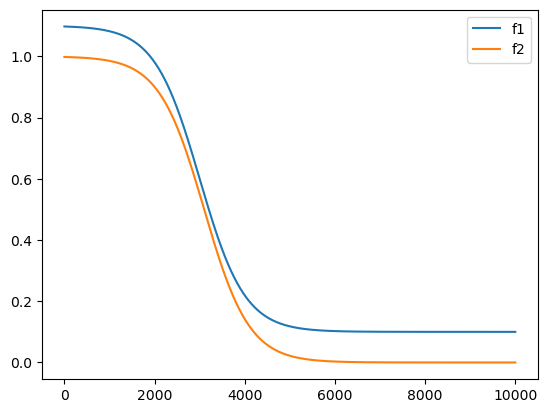

In [56]:
import numpy as np
import matplotlib.pyplot as plt
rng = 1
beta1 = 20
mu1 = 0.3
mu2 = 0.31
numpts = 10000
x = np.linspace(0,rng, numpts)

f = lambda x, beta, mu: 1/(np.exp(beta * (x - mu)) + 1)

f1 = f(x, beta1, mu1) + 0.1
f2 = f(x, beta1, mu2)
smdiff = np.sum(f1-f2)
sgn = smdiff/np.abs(smdiff)
print(f"SUM-DIFF: {np.sum(f2-f1)}")

plt.plot(f1, label = 'f1')
plt.plot(f2, label = 'f2')

plt.legend()

msg = 'f2' if sgn < 0 else 'f1'
print(f"The majorizing function is: {msg}")
invm = calc_invariant_metric(f1, f2)
print(f"The metric is: {invm}")




f1 Sum: 4001.4360675771704
f2 Sum: 3101.2020661128718


0.7507989775543661

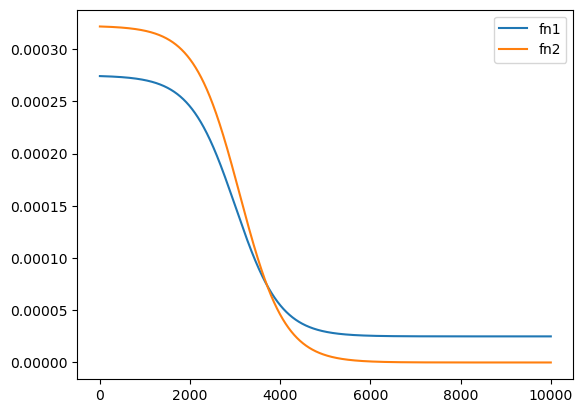

In [57]:


print(f"f1 Sum: {np.sum(f1)}")
print(f"f2 Sum: {np.sum(f2)}")

fn1 = f1/np.sum(f1)
fn2 = f2/np.sum(f2)
invA = 1/np.sum(f2)
corr = (np.dot(fn1, fn2) - invA)/(np.dot(fn1, fn1) - invA) 

plt.plot(fn1, label="fn1")
plt.plot(fn2, label="fn2")

plt.legend()



corr

    
    